# Experiments for Paper

This notebook contains all neural network experiments for the paper. The results are saved as CSV files for independent verification.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from nn_src.imports import *

/export/home/srasp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
DATA_DIR = '/scratch/srasp/ppnn_data/'
RESULTS_DIR = '/export/home/srasp/repositories/ppnn/results/csv_files/'

In [4]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [5]:
def ensemble_scores(m, n, x_trn, y_trn, x_test, y_test, **kwargs):
    trn_scores, test_scores, preds = [], [], []
    for i in tqdm(range(n)):
        reset_weights(m)
        m.fit(x_trn, y_trn, **kwargs)
        trn_scores.append(m.evaluate(x_trn, y_trn, 4096, verbose=0))
        test_scores.append(m.evaluate(x_test, y_test, 4096, verbose=0))
        preds.append(m.predict(x_test, 4096, verbose=0))
    return trn_scores, test_scores, preds

In [6]:
def save_ensemble(preds, test_set, exp_name, save=True):
    preds = np.array(preds)
    preds[:, :, 1] = np.abs(preds[:, :, 1])   # Make sure std is positive
    mean_preds = np.mean(preds, 0)
    ens_score = crps_normal(mean_preds[:, 0], mean_preds[:, 1], test_set.targets).mean()
    print(f'Ensemble test score = {ens_score}')
    if save:
        results_df = create_results_df(test_set.date_strs, test_set.station_ids, mean_preds[:, 0], mean_preds[:, 1])
        print(f'Saved results in {RESULTS_DIR}{exp_name}.csv')
        results_df.to_csv(f'{RESULTS_DIR}{exp_name}.csv')

In [7]:
def get_datasets(pickled_name, train_dates, test_dates=['2016-01-01', '2017-01-01'], aux=False, reload=False):
    pickle_fn = f'{DATA_DIR}pickled/{pickled_name}'
    if not os.path.exists(pickle_fn) or reload:
        var_dict = aux_dict if aux else None
        train_set, test_set = get_train_test_sets(
            DATA_DIR,
            train_dates,
            test_dates,
            aux_dict=var_dict,
        )
        # Save pickled dataset
        with open(pickle_fn, 'wb') as f:
            pickle.dump((train_set, test_set), f)
    else:
        with open(pickle_fn, 'rb') as f:
            train_set, test_set = pickle.load(f)
    return train_set, test_set

## Train 2015

In [8]:
train_set, test_set = get_datasets('15_16.pkl', ['2015-01-01', '2016-01-01'], aux=False)

In [9]:
train_set.features.shape, train_set.targets.shape

((180849, 2), (180849,))

In [10]:
aux_train_set, aux_test_set = get_datasets('aux_15_16.pkl', ['2015-01-01', '2016-01-01'], aux=True)

In [11]:
n_features = aux_train_set.features.shape[1]; n_features

40

### Fully connected network

In [12]:
fc = build_fc_model(2, 2, compile=True, lr=0.1)

In [13]:
fc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [14]:
trn_scores, test_scores, preds = ensemble_scores(
    fc, 10,
    train_set.features, train_set.targets,
    test_set.features, test_set.targets,
    epochs=30, batch_size=4096, verbose=0,
)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [15]:
test_scores

[1.0125660796965648,
 1.0129178457428971,
 1.012704309922172,
 1.0122943711176935,
 1.0127566156530836,
 1.0125142286943547,
 1.0120484974563588,
 1.0122906712949054,
 1.0124105413272844,
 1.0119453056513166]

In [16]:
save_ensemble(preds, test_set, 'fc_15')

Ensemble test score = 1.0123575371041342
Saved results in /export/home/srasp/repositories/ppnn/results/csv_files/fc_15.csv


### Fully connected network with auxiliary data

In [17]:
fc_aux = build_fc_model(n_features, 2, compile=True, lr=0.02)

In [18]:
fc_aux.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 82        
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


In [19]:
trn_scores, test_scores, preds = ensemble_scores(
    fc_aux, 10,
    aux_train_set.features, aux_train_set.targets,
    aux_test_set.features, aux_test_set.targets,
    epochs=30, batch_size=1024, verbose=0,
)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [20]:
test_scores

[0.9203420620311908,
 0.9211336326787011,
 0.9189481733332276,
 0.9177802261132137,
 0.9144752144121381,
 0.9140604637597329,
 0.9182355849052486,
 0.9236554686849325,
 0.9260791716809412,
 0.9197307964775949]

In [21]:
save_ensemble(preds, test_set, 'fc_aux_15')

Ensemble test score = 0.9170064468664917
Saved results in /export/home/srasp/repositories/ppnn/results/csv_files/fc_aux_15.csv


### Neural network with auxiliary data

In [32]:
nn_aux = build_hidden_model(n_features, 2, [32], compile=True, lr=0.02)

In [33]:
nn_aux.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1312      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 66        
Total params: 1,378
Trainable params: 1,378
Non-trainable params: 0
_________________________________________________________________


In [34]:
trn_scores, test_scores, preds = ensemble_scores(
    nn_aux, 10,
    aux_train_set.features, aux_train_set.targets,
    aux_test_set.features, aux_test_set.targets,
    epochs=15, batch_size=1024, verbose=0,
)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [35]:
test_scores

[0.9191673640436318,
 0.9173926617523532,
 0.905769263910095,
 0.9256716399701578,
 0.9433998509272129,
 0.9353543935536064,
 0.9055805974815312,
 0.9223652433392078,
 0.9306803698817591,
 0.9054888254309272]

In [37]:
save_ensemble(preds, aux_test_set, 'nn_aux_15')

Ensemble test score = 0.9004190724401672
Saved results in /export/home/srasp/repositories/ppnn/results/csv_files/nn_aux_15.csv


### Fully connected network with station embeddings

In [38]:
emb_size = 2
max_id = int(np.max([aux_train_set.cont_ids.max(), aux_test_set.cont_ids.max()]))
max_id

536

In [23]:
fc_emb = build_emb_model(2, 2, [], emb_size, max_id, compile=True, lr=0.02)

In [24]:
fc_emb.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 2)         1074        input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2)            0           embedding_1[0][0]                
__________________________________________________________________________________________________
concatenat

In [25]:
trn_scores, test_scores, preds = ensemble_scores(
    fc_emb, 10,
    [train_set.features, train_set.cont_ids], train_set.targets,
    [test_set.features, test_set.cont_ids], test_set.targets,
    epochs=30, batch_size=1024, verbose=0,
)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [26]:
test_scores

[0.9133772596660128,
 0.9127312924215573,
 0.9120425171838975,
 0.9133223066813131,
 0.9181407315524658,
 0.9140805890888852,
 0.91786108869773,
 0.9165114553765853,
 0.9185893787682082,
 0.9163822116124741]

In [27]:
save_ensemble(preds, test_set, 'fc_emb_15')

Ensemble test score = 0.9136206843088861
Saved results in /export/home/srasp/repositories/ppnn/results/csv_files/fc_emb_15.csv


### Fully connected network with auxiliary data and station embeddings

In [28]:
emb_size = 2
max_id = int(np.max([aux_train_set.cont_ids.max(), aux_test_set.cont_ids.max()]))
max_id

536

In [29]:
fc_aux_emb = build_emb_model(n_features, 2, [], emb_size, max_id, compile=True, lr=0.02)

In [30]:
fc_aux_emb.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 2)         1074        input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 2)            0           embedding_2[0][0]                
__________________________________________________________________________________________________
concatenat

In [31]:
trn_scores, test_scores, preds = ensemble_scores(
    fc_aux_emb, 10,
    [aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets,
    [aux_test_set.features, aux_test_set.cont_ids], aux_test_set.targets,
    epochs=30, batch_size=1024, verbose=0,
)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [32]:
test_scores

[0.8787675066552646,
 0.8834953215593282,
 0.8828892295304486,
 0.8774536970301297,
 0.8748253538505735,
 0.8790179064274122,
 0.8796039434379714,
 0.8754884736166001,
 0.8801162208876897,
 0.8757355699212445]

In [33]:
save_ensemble(preds, test_set, 'fc_aux_emb_15')

Ensemble test score = 0.8768901148676806
Saved results in /export/home/srasp/repositories/ppnn/results/csv_files/fc_aux_emb_15.csv


### Neural net with auxiliary data and station embeddings

In [34]:
nn_aux_emb = build_emb_model(n_features, 2, [50], emb_size, max_id, compile=True, lr=0.01)

In [35]:
nn_aux_emb.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 2)         1074        input_8[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 2)            0           embedding_3[0][0]                
__________________________________________________________________________________________________
concatenat

In [36]:
trn_scores, test_scores, preds = ensemble_scores(
    nn_aux_emb, 10,
    [aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets,
    [aux_test_set.features, aux_test_set.cont_ids], aux_test_set.targets,
    epochs=30, batch_size=1024, verbose=0,
)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [37]:
test_scores, np.mean(test_scores), np.std(test_scores)

([0.8530453589331557,
  0.8579773055432763,
  0.8430861228750837,
  0.858902812720452,
  0.8381003905255147,
  0.8455042137387783,
  0.8427825029713915,
  0.8333297892231467,
  0.8639451420802137,
  0.8458852503989227],
 0.8482558889009935,
 0.00934212659468441)

In [38]:
save_ensemble(preds, aux_test_set, 'nn_aux_emb_15')

Ensemble test score = 0.8244155968543407
Saved results in /export/home/srasp/repositories/ppnn/results/csv_files/nn_aux_emb_15.csv


## Train 2007-2015

Note that the first two days of 2007 are missing.

In [10]:
train_set_long, test_set_long = get_datasets('07_16.pkl', ['2007-01-03', '2016-01-01'], aux=False)

In [11]:
train_set_long.features.shape

(1626724, 2)

In [12]:
aux_train_set_long, aux_test_set_long = get_datasets('aux_07_16.pkl', ['2007-01-03', '2016-01-01'], aux=True)

In [13]:
n_features = aux_train_set_long.features.shape[1]; n_features

40

### Fully connected network

In [43]:
fc = build_fc_model(2, 2, compile=True, lr=0.1)

In [44]:
fc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [45]:
trn_scores, test_scores, preds = ensemble_scores(
    fc, 10,
    train_set_long.features, train_set_long.targets,
    test_set_long.features, test_set_long.targets,
    epochs=15, batch_size=4096, verbose=0,
)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [46]:
test_scores

[1.0093966069846034,
 1.0090383981438673,
 1.0091042660435905,
 1.0090859929600622,
 1.008085147305741,
 1.0088784031051576,
 1.009128220275578,
 1.008539821285162,
 1.0096600741597113,
 1.0086962946614597]

In [47]:
save_ensemble(preds, test_set_long, 'fc_07-15')

Ensemble test score = 1.0088650603834994
Saved results in /export/home/srasp/repositories/ppnn/results/csv_files/fc_07-15.csv


### Fully connected network with auxiliary data

In [48]:
fc_aux = build_fc_model(n_features, 2, compile=True, lr=0.02)

In [49]:
fc_aux.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 40)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 82        
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


In [50]:
trn_scores, test_scores, preds = ensemble_scores(
    fc_aux, 10,
    aux_train_set_long.features, aux_train_set_long.targets,
    aux_test_set_long.features, aux_test_set_long.targets,
    epochs=10, batch_size=1024, verbose=0,
)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [51]:
test_scores

[0.9080237805242132,
 0.912771931945068,
 0.9094177026040223,
 0.911351825034327,
 0.9072672559764139,
 0.9102483942824577,
 0.907351270423196,
 0.9144028350793463,
 0.9162569840391469,
 0.9154287296620137]

In [52]:
save_ensemble(preds, aux_test_set_long, 'fc_aux_07-15')

Ensemble test score = 0.9095826085606779
Saved results in /export/home/srasp/repositories/ppnn/results/csv_files/fc_aux_07-15.csv


### Neural network with auxiliary data

In [53]:
nn_aux = build_hidden_model(n_features, 2, [64], compile=True, lr=0.02)

In [54]:
nn_aux.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 40)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2624      
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 130       
Total params: 2,754
Trainable params: 2,754
Non-trainable params: 0
_________________________________________________________________


In [55]:
trn_scores, test_scores, preds = ensemble_scores(
    nn_aux, 10,
    aux_train_set_long.features, aux_train_set_long.targets,
    aux_test_set_long.features, aux_test_set_long.targets,
    epochs=10, batch_size=1024, verbose=0,
)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [56]:
test_scores

[0.8764442595836917,
 0.8695485599281029,
 0.8651237642985253,
 0.8738187604653177,
 0.9102508055886271,
 0.8722111149026253,
 0.9116812391916709,
 0.8687221079462571,
 0.8754405264167037,
 0.8963654558563007]

In [57]:
save_ensemble(preds, aux_test_set_long, 'nn_aux_07-15')

Ensemble test score = 0.8653153955148289
Saved results in /export/home/srasp/repositories/ppnn/results/csv_files/nn_aux_07-15.csv


### Fully connected network with station embeddings

In [14]:
emb_size = 2
max_id = int(np.max([aux_train_set_long.cont_ids.max(), aux_test_set_long.cont_ids.max()]))
max_id

536

In [59]:
fc_emb = build_emb_model(2, 2, [], emb_size, max_id, compile=True, lr=0.02)

In [60]:
fc_emb.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 2)         1074        input_13[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 2)            0           embedding_4[0][0]                
__________________________________________________________________________________________________
concatenat

In [61]:
trn_scores, test_scores, preds = ensemble_scores(
    fc_emb, 10,
    [train_set_long.features, train_set_long.cont_ids], train_set_long.targets,
    [test_set_long.features, test_set_long.cont_ids], test_set_long.targets,
    epochs=10, batch_size=1024, verbose=0,
)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [62]:
test_scores

[0.9073775941172686,
 0.9117906989175043,
 0.9153695128121528,
 0.9141382286743281,
 0.911289841568303,
 0.909289017406526,
 0.9120776073304263,
 0.9114879007851543,
 0.9114514688069608,
 0.9106699530729172]

In [63]:
save_ensemble(preds, test_set_long, 'fc_emb_07-15')

Ensemble test score = 0.90967554001283
Saved results in /export/home/srasp/repositories/ppnn/results/csv_files/fc_emb_07-15.csv


### Fully connected network with auxiliary data and station embeddings

In [64]:
fc_aux_emb = build_emb_model(n_features, 2, [], emb_size, max_id, compile=True, lr=0.02)

In [65]:
fc_aux_emb.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 2)         1074        input_15[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 2)            0           embedding_5[0][0]                
__________________________________________________________________________________________________
concatenat

In [66]:
trn_scores, test_scores, preds = ensemble_scores(
    fc_aux_emb, 10,
    [aux_train_set_long.features, aux_train_set_long.cont_ids], aux_train_set_long.targets,
    [aux_test_set_long.features, aux_test_set_long.cont_ids], aux_test_set_long.targets,
    epochs=10, batch_size=1024, verbose=0,
)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [67]:
test_scores

[0.8710185228253321,
 0.8660293220780229,
 0.8746393906947038,
 0.8696581577523028,
 0.8760017615609512,
 0.8702243193082037,
 0.8716448520412678,
 0.8705175455360857,
 0.8711581081382572,
 0.8767222283394409]

In [68]:
save_ensemble(preds, aux_test_set_long, 'fc_aux_emb_07-15')

Ensemble test score = 0.8695452772176457
Saved results in /export/home/srasp/repositories/ppnn/results/csv_files/fc_aux_emb_07-15.csv


### Neural network with auxiliary data and station embeddings

In [69]:
nn_aux_emb = build_emb_model(n_features, 2, [512], emb_size, max_id, compile=True, lr=0.002)

In [70]:
nn_aux_emb.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 2)         1074        input_17[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 2)            0           embedding_6[0][0]                
__________________________________________________________________________________________________
concatenat

In [71]:
trn_scores, test_scores, preds = ensemble_scores(
    nn_aux_emb, 10,
    [aux_train_set_long.features, aux_train_set_long.cont_ids], aux_train_set_long.targets,
    [aux_test_set_long.features, aux_test_set_long.cont_ids], aux_test_set_long.targets,
    epochs=15, batch_size=4096, verbose=0 
)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [72]:
test_scores

[0.7839185327187141,
 0.7996384344452762,
 0.7909373060819219,
 0.8066875518201129,
 0.794621593876238,
 0.7911308354275469,
 0.7872059220742185,
 0.7798940101220865,
 0.7820173964182585,
 0.7946404840155935]

In [73]:
save_ensemble(preds, aux_test_set, 'nn_aux_emb_07-15')

Ensemble test score = 0.7790718336120384
Saved results in /export/home/srasp/repositories/ppnn/results/csv_files/nn_aux_emb_07-15.csv


## Sensitivity to training length

In [8]:
datasets = {}
datasets['07'] = get_datasets('aux_07_16.pkl', ['2007-01-03', '2016-01-01'], aux=True)
for y in tqdm(range(8, 16)):
    yy = str(y).zfill(2)
    datasets[yy] = get_datasets(f'aux_{yy}_16.pkl', [f'20{yy}-01-03', '2016-01-01'], aux=True)

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

train set contains 2554 days
test set contains 366 days
train set contains 2189 days
test set contains 366 days
train set contains 1824 days
test set contains 366 days
train set contains 1459 days
test set contains 366 days
train set contains 1093 days
test set contains 366 days
train set contains 728 days
test set contains 366 days



In [18]:
fc_scores = []
for y in tqdm(range(7, 16)):
    yy = str(y).zfill(2)
    fc_aux_emb = build_emb_model(n_features, 2, [], emb_size, max_id, compile=True, lr=0.02)
    train_set, test_set = datasets[yy]
    fc_aux_emb.fit([train_set.features, train_set.cont_ids], train_set.targets, 1024, 30, verbose=0)
    fc_scores.append(fc_aux_emb.evaluate(
        [test_set.features, test_set.cont_ids], test_set.targets, 4096, 0))

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

In [19]:
with open('./fc_scores.pkl', 'wb') as f:
    pickle.dump(fc_scores, f)

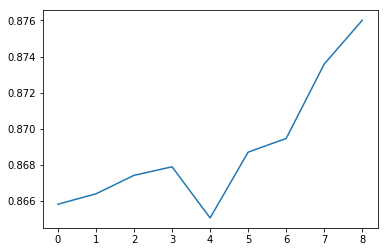

In [21]:
plt.plot(fc_scores)